### Modelo de ML para predicción de precios de steam games

Volvemos a realizar todo el proceso pero desde otro enfoque, transformaremos genres con get_dummies para así tener los géneros en distintas columnas y podes determinar cuales influyen y cuales no. Eliminaremos del df original los nan de early_acces ya que es una variable de interés y no podemos imputarle los valores. Luego eliminaremos la columna de genre"unknown" porque eran los genres nan en el dataframe original. Por último analizaremos si hace falta un balanceo de los datos de early_acces para poder realizar los modelos de predicción.

##### 1) Análisis EDA

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

a) Leemos el archivo limpio, trabajado en el ETL

In [107]:
df = pd.read_csv('steam_games_limpio.csv')

In [108]:
df.head()

,publisher,genres,title,release_date,specs,price,early_access,id,developer,sentiment,metascore,sentiment_code,año
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,2018-01-04,['Single-player'],4.99,False,761140,Kotoshiro,unknown,0,0.0,2018
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,2018-01-04,"['Single-player', 'Multi-player', 'Online Mult...",0.00,False,643980,Secret Level SRL,Mostly Positive,0,6.0,2018
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,2017-07-24,"['Single-player', 'Multi-player', 'Online Mult...",0.00,False,670290,Poolians.com,Mostly Positive,0,6.0,2017
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,2017-12-07,['Single-player'],0.99,False,767400,彼岸领域,unknown,0,0.0,2017
4,Trickjump Games Ltd,"['Action', 'Adventure', 'Simulation']",Battle Royale Trainer,2018-01-04,"['Single-player', 'Steam Achievements']",3.99,False,772540,Trickjump Games Ltd,Mixed,0,4.0,2018


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28750 entries, 0 to 28749
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       28732 non-null  object 
 1   genres          28750 non-null  object 
 2   title           28750 non-null  object 
 3   release_date    28750 non-null  object 
 4   specs           28750 non-null  object 
 5   price           28750 non-null  float64
 6   early_access    28750 non-null  bool   
 7   id              28750 non-null  int64  
 8   developer       28750 non-null  object 
 9   sentiment       28750 non-null  object 
 10  metascore       28750 non-null  int64  
 11  sentiment_code  28743 non-null  float64
 12  año             28750 non-null  int64  
dtypes: bool(1), float64(2), int64(3), object(7)
memory usage: 2.7+ MB


b) Elimino las columnas que no van a ser relevantes ni útiles para el modelo de predicción 

In [110]:
# Para el modelo de ML voy a eliminar la columna ID ya que es irrelevante para el análisis, al igual que titulos (ya que
# si quisiera categorizarla, al haber tantos titulos sería imposible), por este mismo motivo eliminaré también las columnas
# publisher y developer. La columna de release_date, para este análisis de precio será irrelevante, solo nos quedaremos con
# año por si llegaramos a necesitarla
columnas_eliminar = ["id","release_date","title","publisher","developer"]
df = df.drop(columnas_eliminar,axis=1)

c) En este paso separaré las columnas genres y specs para que quede solo un genre y un spec por registro, ya que se encuentran en forma de lista

In [111]:
# Ahora para poder categorizar bien, hare un explode de la columna genres y luego specs para poder codificarlas
df['genres'] = df['genres'].str.split(',')

In [112]:
df = df.explode('genres')

In [113]:
df.head()

,genres,specs,price,early_access,sentiment,metascore,sentiment_code,año
0,['Action',['Single-player'],4.99,False,unknown,0,0.0,2018
0,'Casual',['Single-player'],4.99,False,unknown,0,0.0,2018
0,'Indie',['Single-player'],4.99,False,unknown,0,0.0,2018
0,'Simulation',['Single-player'],4.99,False,unknown,0,0.0,2018
0,'Strategy'],['Single-player'],4.99,False,unknown,0,0.0,2018


In [114]:
# Limpiamos la columna genres de los signos de puntuación que quedaron 
df['genres'] = df['genres'].str.extract(r"'(\w+)'")

In [115]:
# Hacemos lo mismo con specs
df['specs'] = df['specs'].str.split(',')

In [116]:
df = df.explode('specs')

In [117]:
clean_spec = lambda x: x.replace("[", "").replace("]", "").replace("'", "")
# Aplicamos la función lambda a la columna 'specs'
df['specs'] = df['specs'].apply(clean_spec)

In [118]:
df['specs'] = df['specs'].str.replace('-', ' ')

In [119]:
# Reseteamos los índices para no tener inconvenientes
df = df.reset_index(drop=True)

In [120]:
df.head(20)

,genres,specs,price,early_access,sentiment,metascore,sentiment_code,año
0,Action,Single player,4.99,False,unknown,0,0.0,2018
1,Casual,Single player,4.99,False,unknown,0,0.0,2018
2,Indie,Single player,4.99,False,unknown,0,0.0,2018
3,Simulation,Single player,4.99,False,unknown,0,0.0,2018
4,Strategy,Single player,4.99,False,unknown,0,0.0,2018
5,NaN,Single player,0.00,False,Mostly Positive,0,6.0,2018
6,NaN,Multi player,0.00,False,Mostly Positive,0,6.0,2018
7,NaN,Online Multi Player,0.00,False,Mostly Positive,0,6.0,2018
8,NaN,Cross Platform Multiplayer,0.00,False,Mostly Positive,0,6.0,2018
9,NaN,Steam Achievements,0.00,False,Mostly Positive,0,6.0,2018


In [121]:
df.shape

(309581, 8)

d) Tratamos los nuevos nan que hayan aparecido al hacer el explode

In [122]:
df.genres.unique()

array(['Action', 'Casual', 'Indie', 'Simulation', 'Strategy', nan, 'RPG',
       'Sports', 'Adventure', 'Racing', 'Education', 'Utilities',
       'Accounting'], dtype=object)

In [123]:
df.genres.isna().sum()

24784

In [124]:
# Como es necesario usar el género en nuestro modelo de ML por el momento dejaremos a los nan como "desconocido" para no
# perder datos importantes, luego cuando hagamos el encoding, eliminamos la columna de genero desconocido.
df["genres"].fillna("desconocido", inplace=True)

In [125]:
df.genres.unique()

array(['Action', 'Casual', 'Indie', 'Simulation', 'Strategy',
       'desconocido', 'RPG', 'Sports', 'Adventure', 'Racing', 'Education',
       'Utilities', 'Accounting'], dtype=object)

In [126]:
df.specs.unique()
# Al parecer, hay algunos specs duplicados porque tienen un espacio adelante, para intentar reducir esta lista vamos a 
# eliminar estos espacios

array(['Single player', ' Multi player', ' Online Multi Player',
       ' Cross Platform Multiplayer', ' Steam Achievements',
       ' Steam Trading Cards', ' In App Purchases', ' Stats',
       ' Downloadable Content', ' Full controller support',
       ' Steam Cloud', ' Steam Leaderboards',
       ' Partial Controller Support', ' Local Co op',
       ' Shared/Split Screen', 'unknown', ' Valve Anti Cheat enabled',
       ' Co op', ' Captions available', ' Steam Workshop',
       ' Includes level editor', 'Multi player', ' Mods', ' MMO',
       ' Online Co op', ' Local Multi Player', ' Includes Source SDK',
       'Downloadable Content', ' Commentary available', 'Co op',
       ' Steam Turn Notifications', 'Partial Controller Support', 'MMO',
       'Steam Cloud', 'Steam Achievements', 'Shared/Split Screen',
       'Includes level editor', 'Online Multi Player',
       'Local Multi Player', 'Captions available', 'Steam Trading Cards',
       'In App Purchases', 'Commentary available', 

In [127]:
df['specs'] = df['specs'].str.strip()

In [128]:
df.specs.unique()
# Redució la lista significativamente

array(['Single player', 'Multi player', 'Online Multi Player',
       'Cross Platform Multiplayer', 'Steam Achievements',
       'Steam Trading Cards', 'In App Purchases', 'Stats',
       'Downloadable Content', 'Full controller support', 'Steam Cloud',
       'Steam Leaderboards', 'Partial Controller Support', 'Local Co op',
       'Shared/Split Screen', 'unknown', 'Valve Anti Cheat enabled',
       'Co op', 'Captions available', 'Steam Workshop',
       'Includes level editor', 'Mods', 'MMO', 'Online Co op',
       'Local Multi Player', 'Includes Source SDK',
       'Commentary available', 'Steam Turn Notifications',
       'SteamVR Collectibles', 'Game demo', 'Mods (require HL2)'],
      dtype=object)

In [129]:
df.specs.isna().sum()
# No hay nans en specs

0

e) Encoding de variables para convertirlas a categóricas, ya que los modelos no admiten variables str:
Primero probaremos hacer label encoding a ambas columnas (genres y specs), luego probaremos hacer dummies a la columna genres que es de nuestro mayor interes, para ver con cual obtenemos mejores resultados

In [130]:
# Ahora si aplicamos label encoding a estas dos columnas (porque si quiseramos hacer one hot encoding nos agregaría
# demasiadas columnas lo que haría el modelo muy pesado para la API)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['specs_encoded'] = label_encoder.fit_transform(df['specs'])
df = pd.get_dummies(df, columns=['genres'], prefix='', prefix_sep='')

In [131]:
df.head()

,specs,price,early_access,sentiment,metascore,sentiment_code,año,specs_encoded,Accounting,Action,...,Casual,Education,Indie,RPG,Racing,Simulation,Sports,Strategy,Utilities,desconocido
0,Single player,4.99,False,unknown,0,0.0,2018,20,False,True,...,False,False,False,False,False,False,False,False,False,False
1,Single player,4.99,False,unknown,0,0.0,2018,20,False,False,...,True,False,False,False,False,False,False,False,False,False
2,Single player,4.99,False,unknown,0,0.0,2018,20,False,False,...,False,False,True,False,False,False,False,False,False,False
3,Single player,4.99,False,unknown,0,0.0,2018,20,False,False,...,False,False,False,False,False,True,False,False,False,False
4,Single player,4.99,False,unknown,0,0.0,2018,20,False,False,...,False,False,False,False,False,False,False,True,False,False


f) Tratamos los nans del resto de las columnas (sentiment_code y metascore). Por el momento los dejaremos

In [ ]:
"""# En el ETL imputamos el valor cero a los datos de metascore vacios, y 0.0 a sentiment_code en los cuales el registro era
# nan, si bien si eliminamos esos datos perderemos gran cantidad de informacion, vamos a ver si en esa porción de datos que 
# nos quedan luego de eliminar conseguimos algún patrón más consistente de datos
df_metascore0 = df[df["metascore"]==0]
df_sentiment0 = df[df["sentiment_code"]==0.0]
num_registros_metascore0 = df_metascore0.shape[0]
num_registros_sentiment0 = df_sentiment0.shape[0]
print("los nan de metascore son:",num_registros_metascore0, "y los nan de sentiment son:", num_registros_sentiment0)"""

In [ ]:
"""indices_a_eliminar = df[df["metascore"]==0].index.union(df[df["sentiment_code"]==0.0].index)
df_sin_nans = df.drop(indices_a_eliminar)
df_sin_nans.shape"""

f) Seleccionamos las columnas con las que trabajaremos y hacemos nuestro análisis exploratorio: correlaciones, heatmap, diagrama de caja y bigotes, histogramas, etc

In [132]:
# Ahora ya estamos en condiciones de usar nuestras columnas numéricas y booleanas para el análisis 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309581 entries, 0 to 309580
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   specs           309581 non-null  object 
 1   price           309581 non-null  float64
 2   early_access    309581 non-null  bool   
 3   sentiment       309581 non-null  object 
 4   metascore       309581 non-null  int64  
 5   sentiment_code  309538 non-null  float64
 6   año             309581 non-null  int64  
 7   specs_encoded   309581 non-null  int32  
 8   Accounting      309581 non-null  bool   
 9   Action          309581 non-null  bool   
 10  Adventure       309581 non-null  bool   
 11  Casual          309581 non-null  bool   
 12  Education       309581 non-null  bool   
 13  Indie           309581 non-null  bool   
 14  RPG             309581 non-null  bool   
 15  Racing          309581 non-null  bool   
 16  Simulation      309581 non-null  bool   
 17  Sports    

In [133]:
columnas = ["early_access","specs_encoded","sentiment_code","metascore","año","Accounting","Action","Adventure", \
            "Casual","Education","Indie","RPG","Racing","Simulation","Sports","Strategy","Utilities","price"] 
# No incluimos la columna de genero desconocido
df_filtrado = df[columnas]
df_filtrado.head()

,early_access,specs_encoded,sentiment_code,metascore,año,Accounting,Action,Adventure,Casual,Education,Indie,RPG,Racing,Simulation,Sports,Strategy,Utilities,price
0,False,20,0.0,0,2018,False,True,False,False,False,False,False,False,False,False,False,False,4.99
1,False,20,0.0,0,2018,False,False,False,True,False,False,False,False,False,False,False,False,4.99
2,False,20,0.0,0,2018,False,False,False,False,False,True,False,False,False,False,False,False,4.99
3,False,20,0.0,0,2018,False,False,False,False,False,False,False,False,True,False,False,False,4.99
4,False,20,0.0,0,2018,False,False,False,False,False,False,False,False,False,False,True,False,4.99


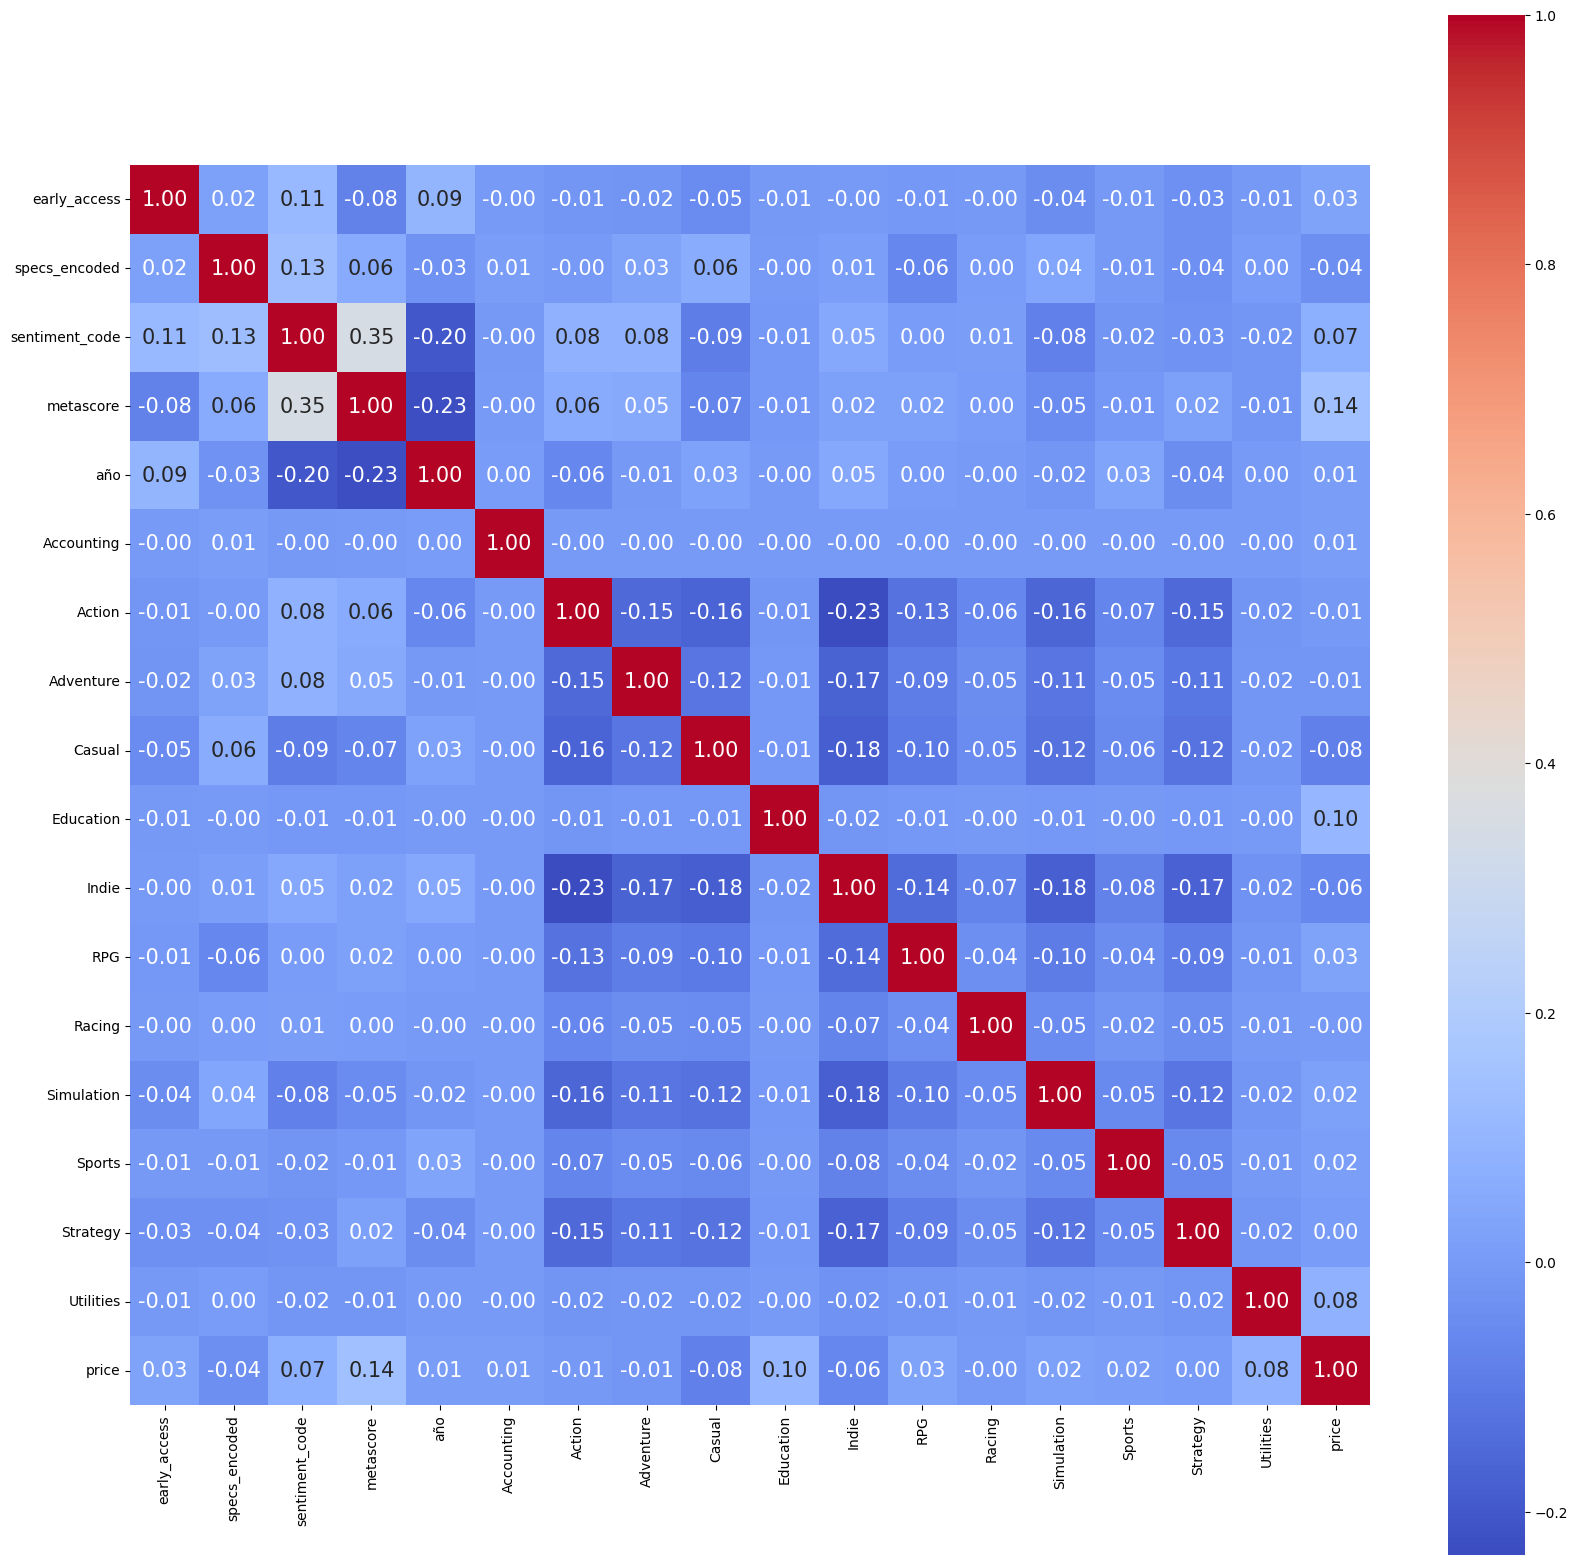

In [134]:
# Al parecer no hay nada que indique fuertes correlaciones, pero podemos eliminar algunos generos que tiene cero 
# correlación con el precio
corr = df_filtrado.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_filtrado.columns,
           yticklabels= df_filtrado.columns,
           cmap= 'coolwarm')
plt.show()

In [146]:
columnas = ["early_access","specs_encoded","metascore","año","Casual",\
            "Education","Indie","RPG","Simulation","Sports","Utilities","price"] 
# No incluimos la columna de genero desconocido y sentiment_code ya que está correlacionada con metascore
df_filtrado = df[columnas]
df_filtrado.head()

,early_access,specs_encoded,metascore,año,Casual,Education,Indie,RPG,Simulation,Sports,Utilities,price
0,False,20,0,2018,False,False,False,False,False,False,False,4.99
1,False,20,0,2018,True,False,False,False,False,False,False,4.99
2,False,20,0,2018,False,False,True,False,False,False,False,4.99
3,False,20,0,2018,False,False,False,False,True,False,False,4.99
4,False,20,0,2018,False,False,False,False,False,False,False,4.99


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


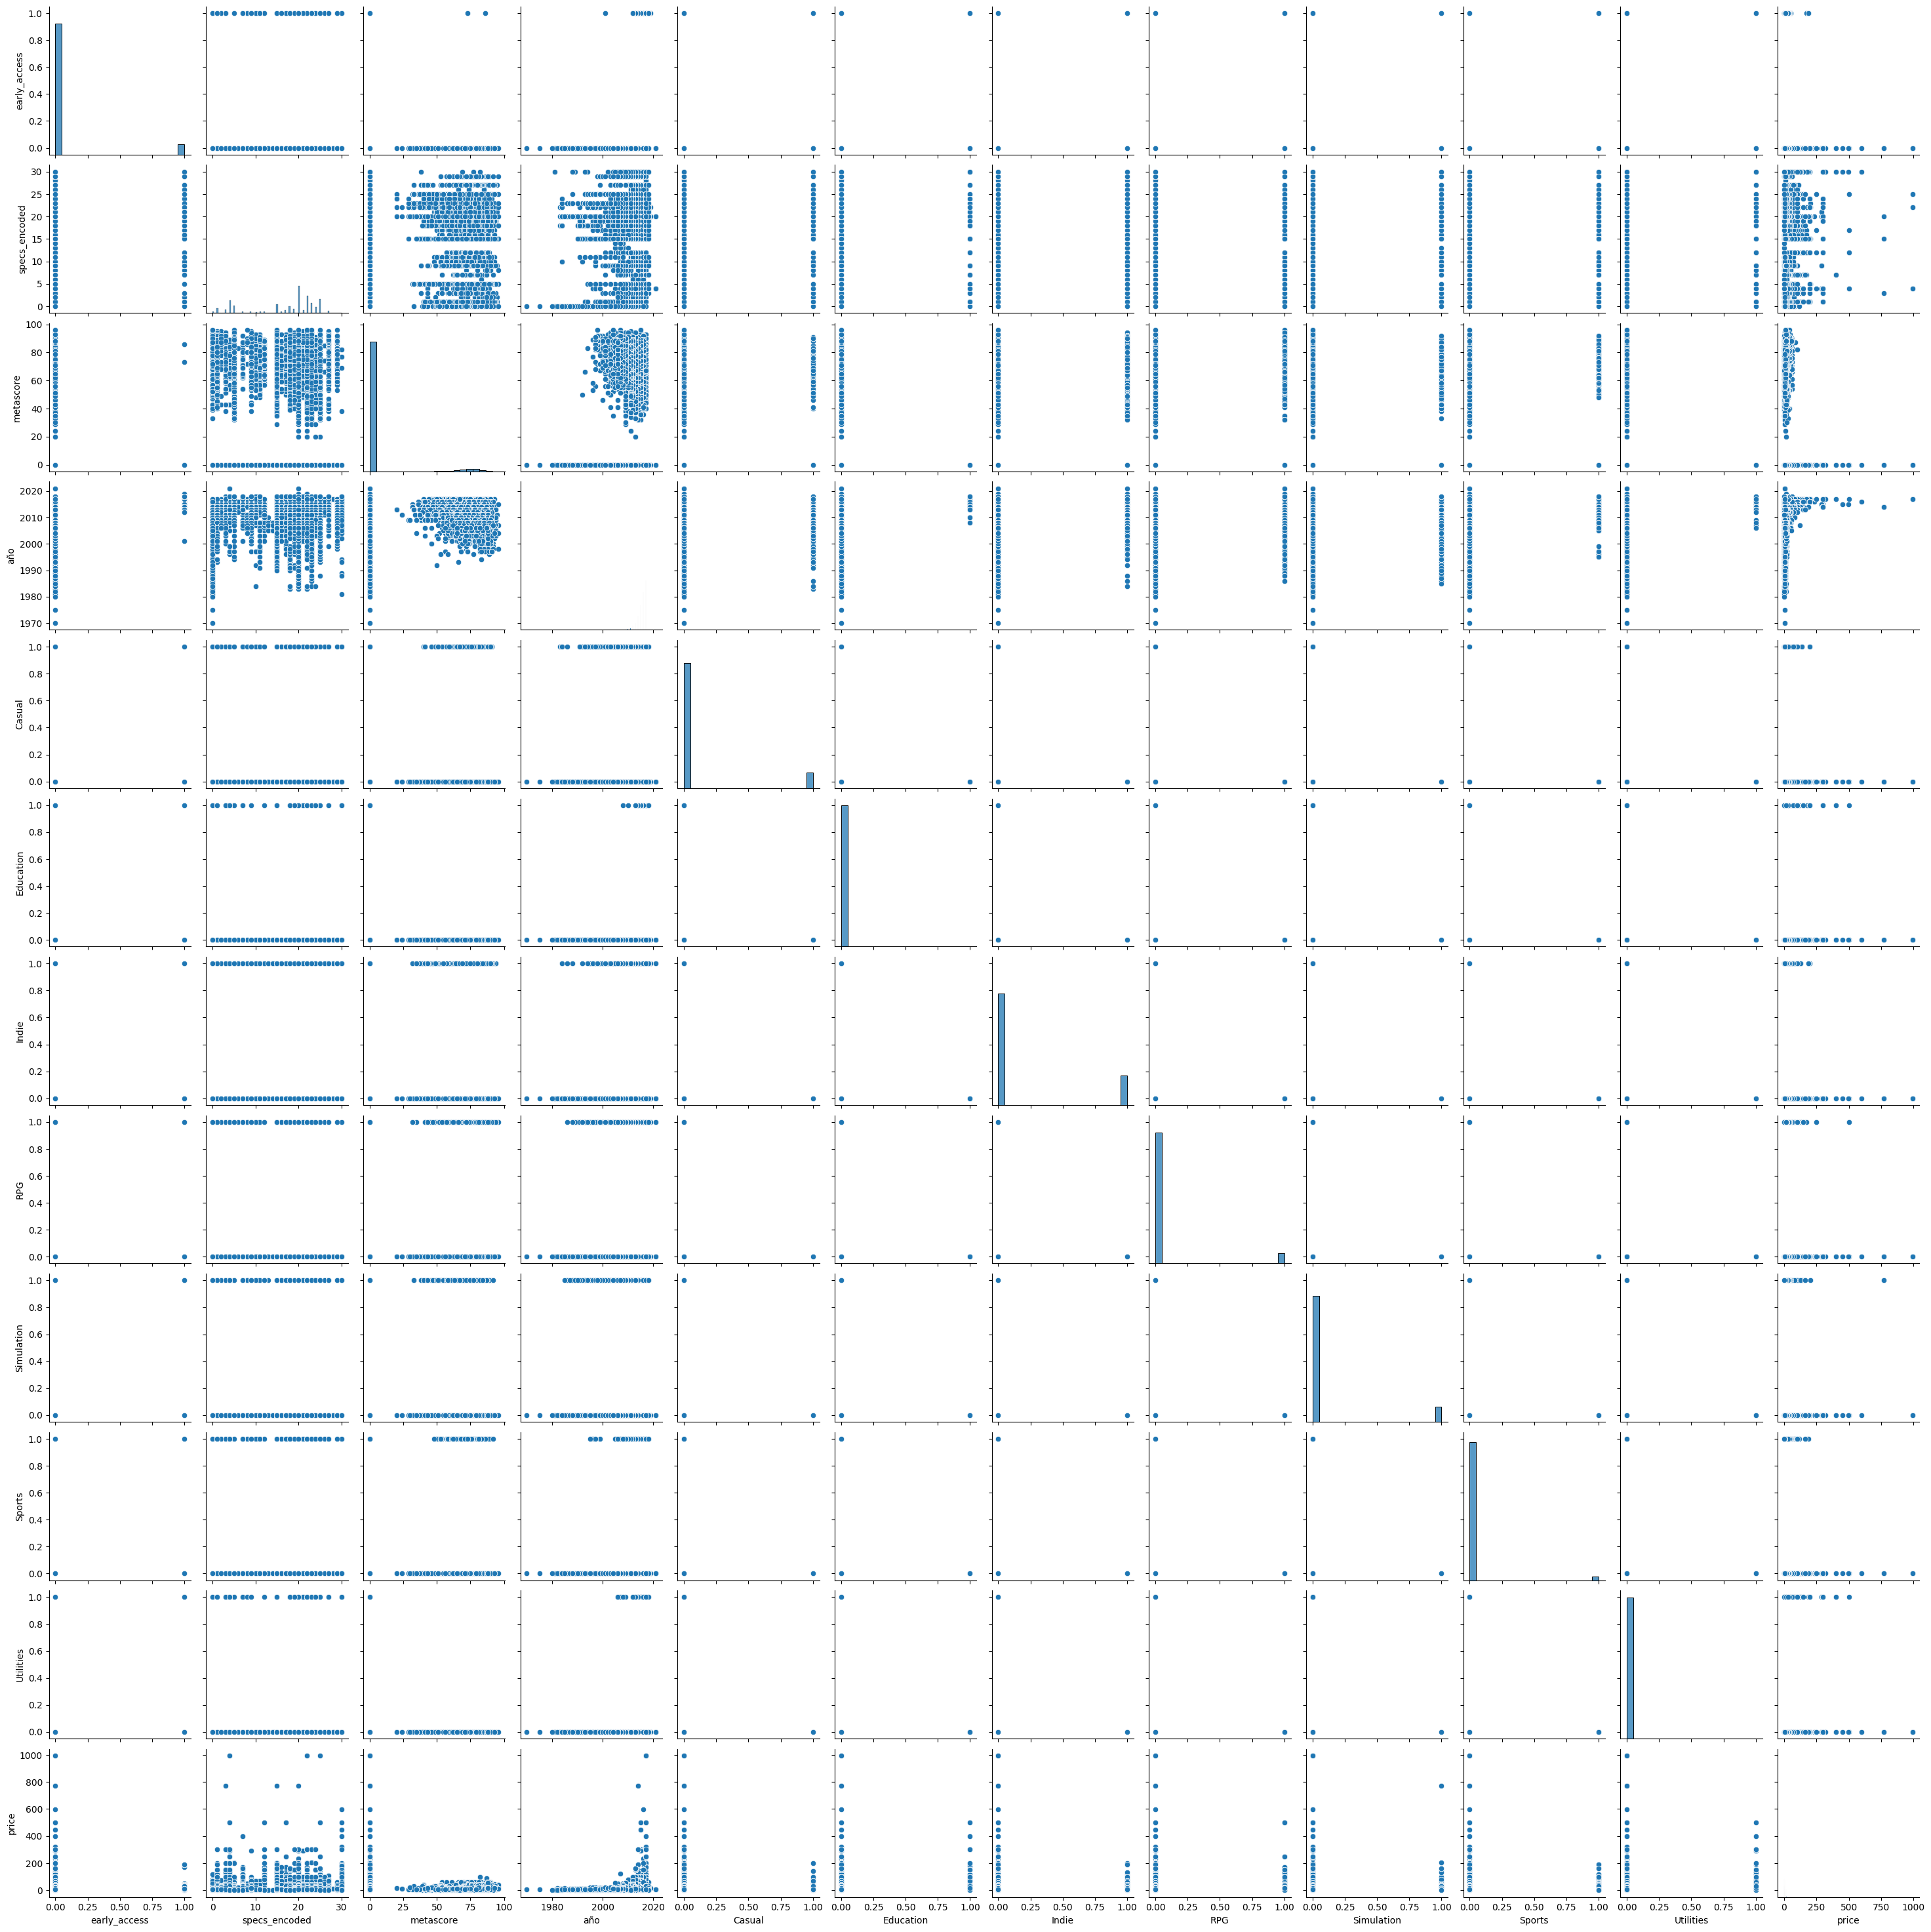

In [147]:
sns.pairplot(data=df_filtrado)
plt.show()
# Vemos que el gráfico no se aprecia muy bien debido a los outliers

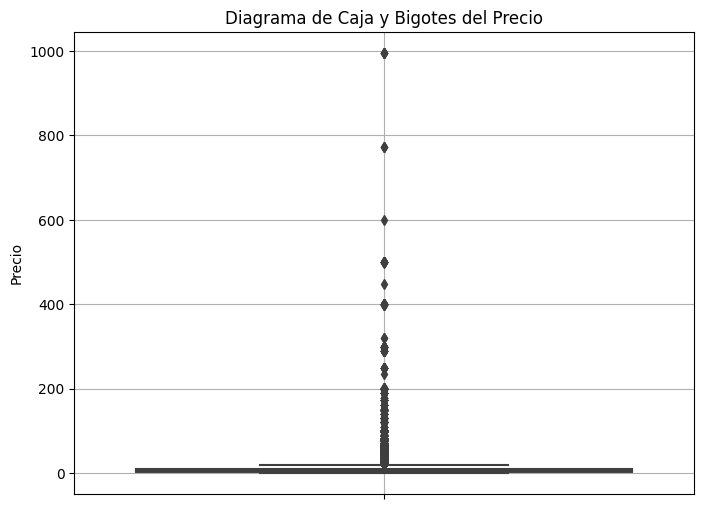

In [149]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtrado, y='price')
plt.title('Diagrama de Caja y Bigotes del Precio')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

In [150]:
# Vemos algunos outliers en precio
outliers100 = (df['price'] > 100).sum()
outliers50 = (df['price'] > 50).sum()
print(outliers50, "el porcentaje sobre los datos totales de los outliers >50 es", (outliers50/df.shape[0])*100,"%")
print(outliers100, "el porcentaje sobre los datos totales de los outliers >100 es", (outliers100/df.shape[0])*100,"%")
print("Nos quedaremos con los precios entre 0 y 100")
# Al ser una cantidad insignificante para el número de datos que tenemos, y viendo que la mayor cantidad de datos se
# de concentra entre 0 y 100, vamos a proceder a elimnarlos y quedarnos con lo que nos interesa para volver a hacer 
# el pairplot y heatmap

3467 el porcentaje sobre los datos totales de los outliers >50 es 1.119900769104047 %
528 el porcentaje sobre los datos totales de los outliers >100 es 0.17055310241907612 %
Nos quedaremos con los precios entre 0 y 100


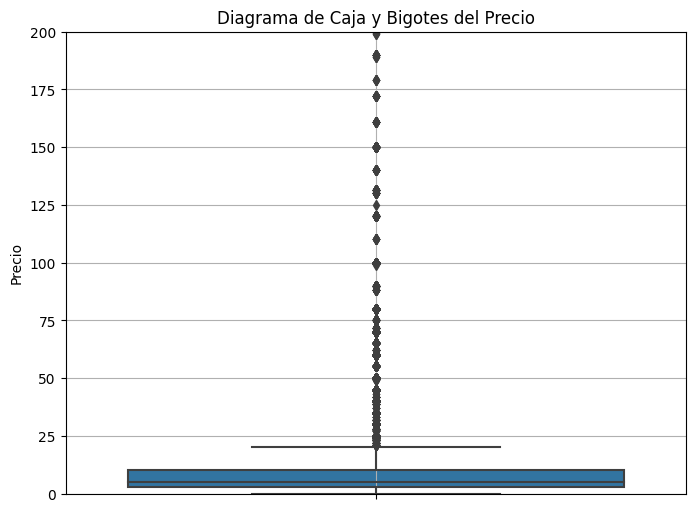

In [151]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtrado, y='price')
plt.title('Diagrama de Caja y Bigotes del Precio')
plt.ylim(0, 200)  # Establecemos los límites en el eje y entre 0 y 200 porque hay muy pocos valores por fuera
plt.ylabel('Precio')
plt.grid(True)
plt.show()


In [152]:
#Filtramos el df para los precios 
df_100 = df_filtrado[df_filtrado['price'] <= 100]

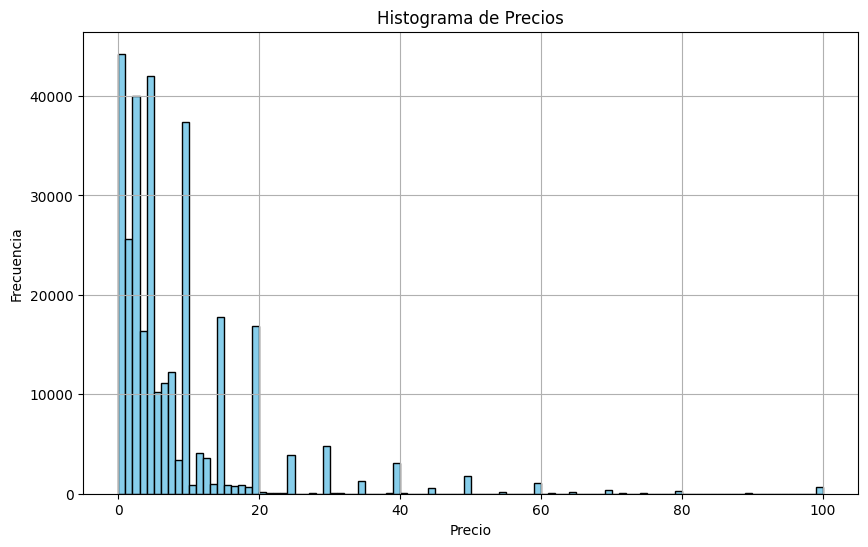

In [153]:
plt.figure(figsize=(10, 6))

plt.hist(df_100['price'], bins=100, color='skyblue', edgecolor='black')

# Personalizar el gráfico
plt.title('Histograma de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)

In [154]:
df_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309053 entries, 0 to 309580
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   early_access   309053 non-null  bool   
 1   specs_encoded  309053 non-null  int32  
 2   metascore      309053 non-null  int64  
 3   año            309053 non-null  int64  
 4   Casual         309053 non-null  bool   
 5   Education      309053 non-null  bool   
 6   Indie          309053 non-null  bool   
 7   RPG            309053 non-null  bool   
 8   Simulation     309053 non-null  bool   
 9   Sports         309053 non-null  bool   
 10  Utilities      309053 non-null  bool   
 11  price          309053 non-null  float64
dtypes: bool(8), float64(1), int32(1), int64(2)
memory usage: 13.0 MB


Rehacemos el pairplot y heatmap pero solo teniendo en cuenta los precios menores o iguales a 100

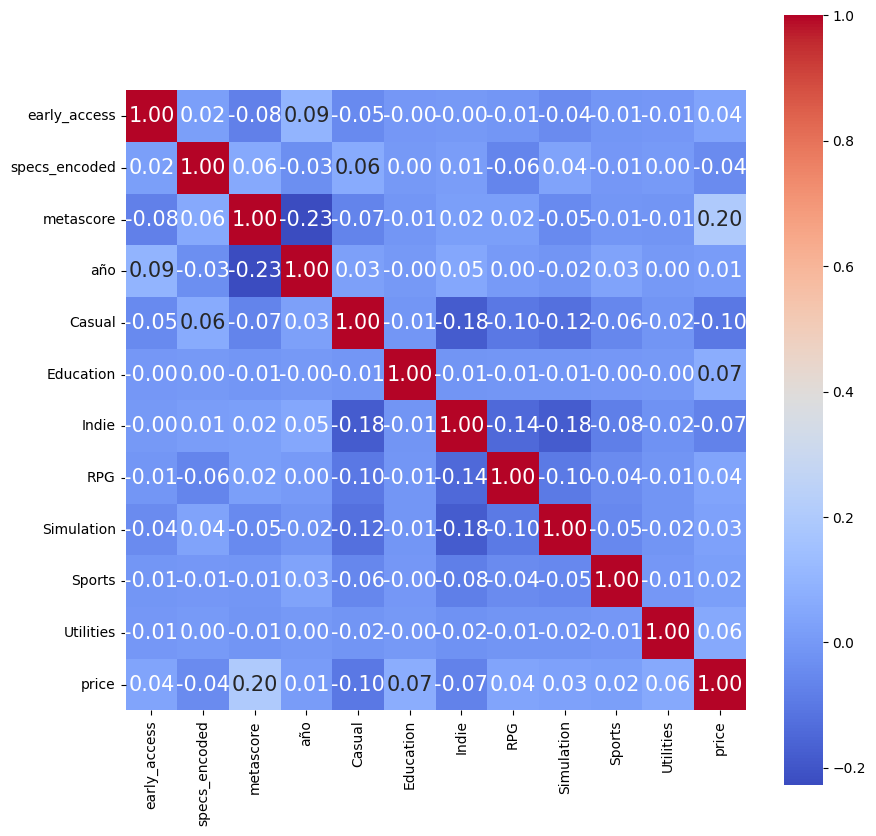

In [155]:
corr = df_100.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= df_100.columns,
           yticklabels= df_100.columns,
           cmap= 'coolwarm')
plt.show()

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


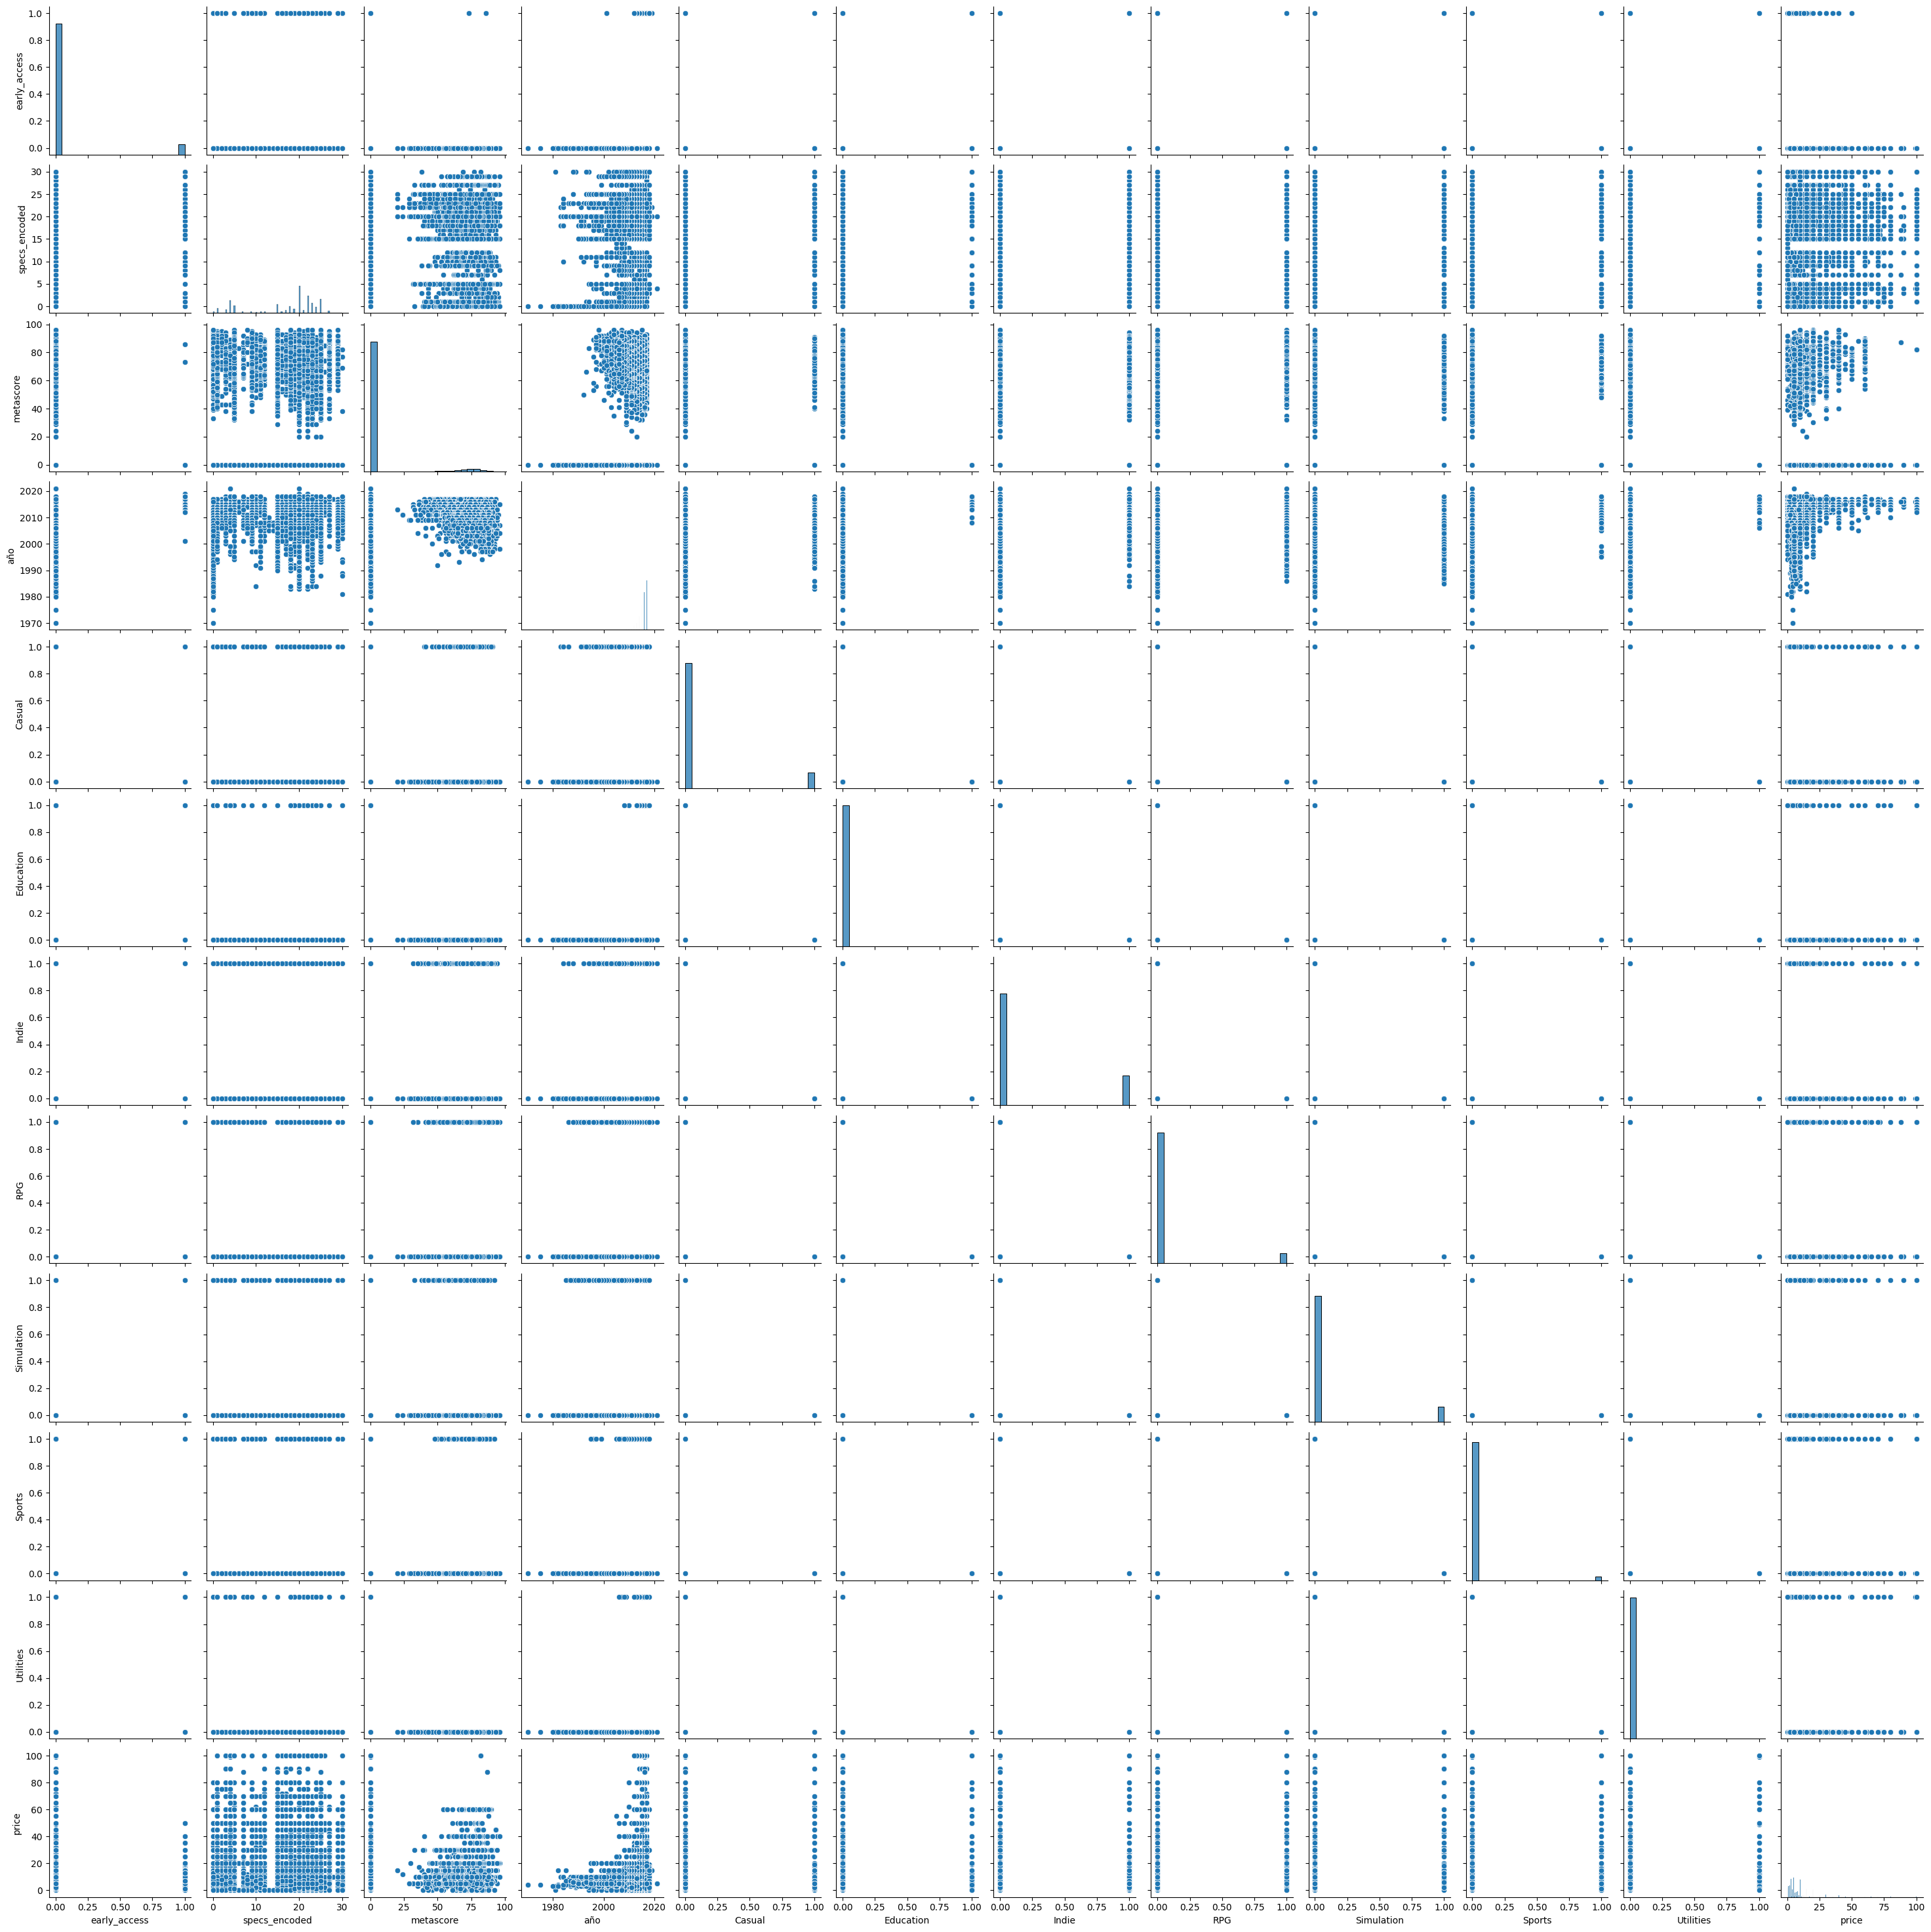

In [156]:
sns.pairplot(data=df_100)
plt.show()

In [157]:
df_filtrado["early_access"].value_counts()

early_access
False    287265
True      22316
Name: count, dtype: int64

- Podríamos hacer un balanceo de early_access pero por el momento no

In [510]:
""" #Contar la cantidad de muestras en cada clase
counts = df_sin_nans['early_access'].value_counts()

# Obtener el tamaño de la clase mayoritaria (False)
majority_class_size = counts[False]

# Obtener todas las muestras de la clase minoritaria (True)
df_minority = df_sin_nans[df_sin_nans['early_access'] == True]

# Hacer un sobremuestreo replicando las muestras de la clase minoritaria
df_oversampled = df_minority.sample(majority_class_size, replace=True, random_state=42)

# Combinar ambos DataFrames para obtener el sobremuestreo final
df_balanced = pd.concat([df_sin_nans[df_sin_nans['early_access'] == False], df_oversampled])

# Verificar el balance en la columna 'early_access'
print(df_balanced['early_access'].value_counts()) """


early_access
False    23751
True     23751
Name: count, dtype: int64


- También podemos notar que año no tiene mucha correlación con precio pero si hay una tendencia al alza en el precio según el año, por lo tanto lo mantendremos en el modelo. Por su parte specs_encoded no aporta mucho valor debido a la cantidad de variantes que tiene, probaremos eliminándolas a ver como nos quedan los gráficos

In [158]:
eliminar = ["specs_encoded"]
df_100 = df_100.drop(eliminar,axis=1)

In [159]:
df_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309053 entries, 0 to 309580
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   early_access  309053 non-null  bool   
 1   metascore     309053 non-null  int64  
 2   año           309053 non-null  int64  
 3   Casual        309053 non-null  bool   
 4   Education     309053 non-null  bool   
 5   Indie         309053 non-null  bool   
 6   RPG           309053 non-null  bool   
 7   Simulation    309053 non-null  bool   
 8   Sports        309053 non-null  bool   
 9   Utilities     309053 non-null  bool   
 10  price         309053 non-null  float64
dtypes: bool(8), float64(1), int64(2)
memory usage: 11.8 MB


##### 2) Comenzamos con los modelos de predicción con las variables que tenemos, si bien hay un poco de correlación entre metascore y early_access, luego determinaremos con feature_importances con cual quedarnos para hacer más simple el modelo

a- Regresión lineal múltiple

In [161]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [162]:
feature_cols = ["early_access","metascore","año","Casual","Education","Indie","RPG","Simulation","Sports","Utilities"]
X = df_100[feature_cols]
y = df_100["price"]

x1 = X[["early_access"]]
x2 = X[["metascore"]]
x3 = X[["año"]]
x4 = X[["Casual"]]
x5 = X[["Education"]]
x6 = X[["Indie"]]
x7 = X[["RPG"]]
x8 = X[["Simulation"]]
x9 = X[["Sports"]]
x10 = X[["Utilities"]]

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) #chequear que quede de la forma (n,3) (n,) (n_test,3) (n,)


(309053, 10) (309053,)
(247242, 10) (247242,) (61811, 10) (61811,)


In [163]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del regresor "R2" es:', r2)
rmse_train = (mean_squared_error(y_train, y_train_pred, squared = False))
rmse_test = (mean_squared_error(y_test, y_test_pred, squared = False))
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del regresor "R2" es: 0.07242673928587229
Raíz del error cuadrático medio en Train (RMSE): 10.149079954867595
Raíz del error cuadrático medio en Test (RMSE): 10.176079462975236


b- Arbol de regresión

In [164]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

tree_model = DecisionTreeRegressor()

tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del regresor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')


El coeficiente de determinación del regresor "R2" es: 0.12059288798927614
Raíz del error cuadrático medio en Train (RMSE): 9.882061454538636
Raíz del error cuadrático medio en Test (RMSE): 9.936076133412818


c- Random forest

In [165]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=20 ,random_state=42)

rf_regressor.fit(X_train, y_train)

y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)


r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del random forest regressor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del random forest regressor "R2" es: 0.12045245030706253
Raíz del error cuadrático medio en Train (RMSE): 9.882850485230227
Raíz del error cuadrático medio en Test (RMSE): 9.937073547270511


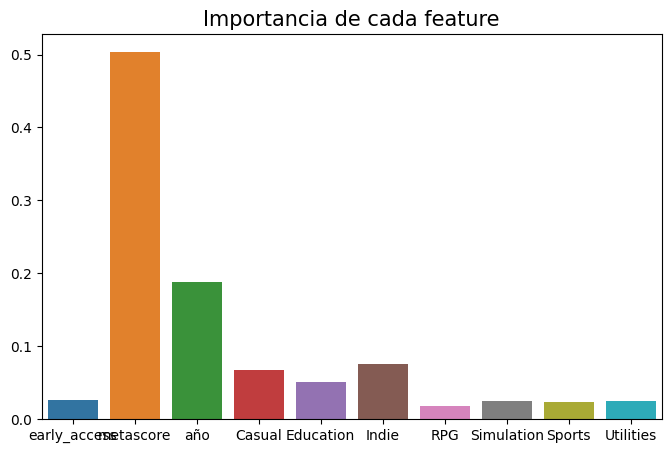

In [166]:
# Feature importances
plt.figure(figsize = (8,5))
importances = rf_regressor.feature_importances_
columns = X.columns
sns.barplot(x = columns, y = importances)
plt.title('Importancia de cada feature', fontsize = 15)
plt.show()

- Dadas estas feature importances, eliminaremos las columnas que no tienen incidencia en el modelo

In [167]:
eliminar = ["RPG","Simulation","Sports","Utilities"]
df_100 = df_100.drop(eliminar,axis=1)

In [168]:
feature_cols = ["early_access","metascore","año","Casual","Education","Indie"]
X = df_100[feature_cols]
y = df_100["price"]

x1 = X[["early_access"]]
x2 = X[["metascore"]]
x3 = X[["año"]]
x4 = X[["Casual"]]
x5 = X[["Education"]]
x6 = X[["Indie"]]

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) #chequear que quede de la forma (n,3) (n,) (n_test,3) (n,)

(309053, 6) (309053,)
(247242, 6) (247242,) (61811, 6) (61811,)


In [197]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del regresor "R2" es:', r2)
rmse_train = (mean_squared_error(y_train, y_train_pred, squared = False))
rmse_test = (mean_squared_error(y_test, y_test_pred, squared = False))
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del regresor "R2" es: 0.13147478451358385
Raíz del error cuadrático medio en Train (RMSE): 10.387435196182857
Raíz del error cuadrático medio en Test (RMSE): 10.468193750297056


In [196]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=20 ,random_state=42)

rf_regressor.fit(X_train, y_train)

y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)


r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del random forest regressor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del random forest regressor "R2" es: 0.3671574649779763
Raíz del error cuadrático medio en Train (RMSE): 8.866759773984654
Raíz del error cuadrático medio en Test (RMSE): 9.310230034758757


In [192]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

tree_model = DecisionTreeRegressor()

tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del regresor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del regresor "R2" es: 0.3676657235269809
Raíz del error cuadrático medio en Train (RMSE): 8.86319845230862
Raíz del error cuadrático medio en Test (RMSE): 9.308082680065525


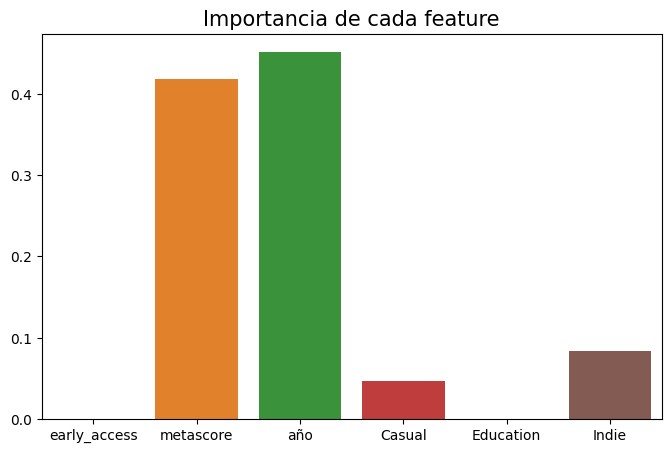

In [195]:
# IMPORTANCIA DE FEATURES EN LA PREDICCIÓN
plt.figure(figsize = (8,5))
importances = gb_regressor.feature_importances_
columns = X.columns
sns.barplot(x = columns, y = importances)
plt.title('Importancia de cada feature', fontsize = 15)
plt.show()

d- GradientBoostingRegressor

In [193]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

gb_regressor.fit(X_train, y_train)

y_test_pred = gb_regressor.predict(X_test)
y_train_pred = gb_regressor.predict(X_train)


r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del random forest regressor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')


El coeficiente de determinación del random forest regressor "R2" es: 0.2350895827784476
Raíz del error cuadrático medio en Train (RMSE): 9.748154400733082
Raíz del error cuadrático medio en Test (RMSE): 9.922164677818033


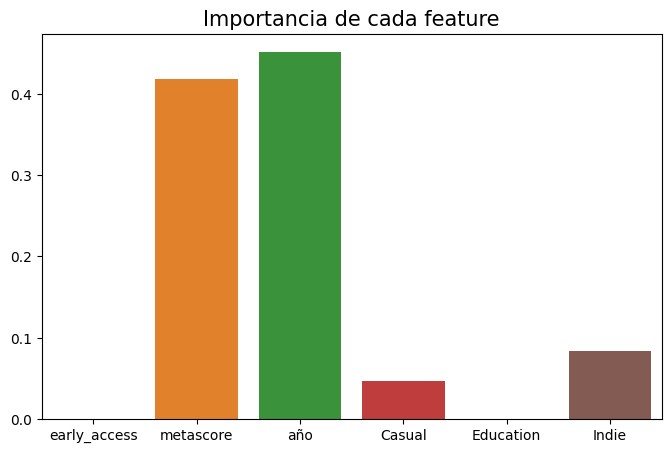

In [194]:
# IMPORTANCIA DE FEATURES EN LA PREDICCIÓN
plt.figure(figsize = (8,5))
importances = gb_regressor.feature_importances_
columns = X.columns
sns.barplot(x = columns, y = importances)
plt.title('Importancia de cada feature', fontsize = 15)
plt.show()

Comparando con el modelo anterior, las diferencias que aplicamos fue usar dummies en vez de label encoder, para profundizar en los géneros más importantes.
Otra diferencia fue tomar TODOS los valores de metascore, incluido los ceros(que correspondían a nan en el dataset original, suponiendo que si no tenía puntaje es porque no fue un buen juego), pero en general cuando las personas tienen una mala experiencia es cuando más dejan sus reviews, por lo que esos nans son realmente inciertos, vamos a probar borrando los ceros(nans) de metascore a ver como se comporta nuestro modelo

In [185]:
# En el ETL imputamos el valor cero a los datos de metascore vacios, y 0.0 a sentiment_code en los cuales el registro era
# nan, si bien si eliminamos esos datos perderemos gran cantidad de informacion, vamos a ver si en esa porción de datos que 
# nos quedan luego de eliminar conseguimos algún patrón más consistente de datos
df_metascore0 = df_100[df_100["metascore"]==0]

num_registros_metascore0 = df_metascore0.shape[0]

print("los nan de metascore son:",num_registros_metascore0)

print("el numero total de registros es:",df_100.shape[0])

los nan de metascore son: 283804
el numero total de registros es: 309053


In [188]:
indices_a_eliminar = df_100[df_100["metascore"]==0].index
df_sin_nans = df_100.drop(indices_a_eliminar)
df_sin_nans.shape

(25249, 7)

Rehacemos los modelos con este nuevo df sin nans en metascore y con las columnas que ya habíamos decidido que eran importantes

In [189]:
feature_cols = ["early_access","metascore","año","Casual","Education","Indie"]
X = df_sin_nans[feature_cols]
y = df_sin_nans["price"]

x1 = X[["early_access"]]
x2 = X[["metascore"]]
x3 = X[["año"]]
x4 = X[["Casual"]]
x5 = X[["Education"]]
x6 = X[["Indie"]]

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) #chequear que quede de la forma (n,3) (n,) (n_test,3) (n,)

(25249, 6) (25249,)
(20199, 6) (20199,) (5050, 6) (5050,)


In [198]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del regresor "R2" es:', r2)
rmse_train = (mean_squared_error(y_train, y_train_pred, squared = False))
rmse_test = (mean_squared_error(y_test, y_test_pred, squared = False))
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del regresor "R2" es: 0.13147478451358385
Raíz del error cuadrático medio en Train (RMSE): 10.387435196182857
Raíz del error cuadrático medio en Test (RMSE): 10.468193750297056


In [199]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

tree_model = DecisionTreeRegressor()

tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del regresor "R2" es:', r2)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')

El coeficiente de determinación del regresor "R2" es: 0.3676657235269809
Raíz del error cuadrático medio en Train (RMSE): 8.86319845230862
Raíz del error cuadrático medio en Test (RMSE): 9.307912486809494


Luego de hacer la prueba con los diferentes modelos, vemos que tree_regresor y random forest nos dan buenos resultados, vamos a intentar mejorar el performance con un grid search en el modelo de random forest

In [200]:
from sklearn.model_selection import GridSearchCV

# Defino la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Creo el modelo RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

# Creo un objeto GridSearchCV con el modelo y la cuadrícula de hiperparámetros
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, n_jobs=-1)

# Realizo la búsqueda de hiperparámetros con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo con los hiperparámetros encontrados
best_rf_regressor = grid_search.best_estimator_

# Realizo predicciones con el mejor modelo
y_train_pred = best_rf_regressor.predict(X_train)
y_test_pred = best_rf_regressor.predict(X_test)

# Calculamos las métricas de rendimiento de este mejor modelo
r2 = r2_score(y_train, y_train_pred)
print('El coeficiente de determinación del random forest regressor "R2" es:', r2)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'Raíz del error cuadrático medio en Train (RMSE): {rmse_train}')
print(f'Raíz del error cuadrático medio en Test (RMSE): {rmse_test}')


El coeficiente de determinación del random forest regressor "R2" es: 0.3672445761887023
Raíz del error cuadrático medio en Train (RMSE): 8.866149495188303
Raíz del error cuadrático medio en Test (RMSE): 9.310430728252598


In [201]:
# Obtener los mejores hiperparámetros y el mejor modelo para RandomForestRegressor
best_params_rf = grid_search.best_params_
best_model_rf = grid_search.best_estimator_
print(best_params_rf)
print(best_model_rf)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


La conclusión de este segundo proceso es que podemos quedarnos con el RandomForestRegressor ajustando los hiperparámetros a los resultados del grid search, pero obtenemos mejores resultados usando label encoder en la variable genres como vimos en los modelos del archivo Analisis EDA y ML 1, siempre y cuando eliminemos los nans de metascore. 

### CONCLUSIONES DEL ANÁLISIS

- Usando el método de get dummies para codificar la variable genres se obtuvieron no tan buenos resultados

- Por lo que nos quedamos con el uso del encoding realizado con label encoder para la variable genres

- Teniendo en cuenta los nans de metascore el modelo es muy malo prediciendo por lo que decidimos eliminarlos además de la razón mencionada anteriormente al momento de la eliminación

- Balanceando la variable early_access se obtienen mejores resultados aún

- Decidimos quedarnos entonces con el modelo de TreeRegressor usando el data frame final del archivo Análisis EDA y ML 1

- A continuación dejo el modelo que se guardará en un archivo .pkl para entrenarlo y deployarlo en la API como un modelo ya entrenado ahorrando considerablemente el costo computacional


### Creación de archivo pkl con modelo entrenado seleccionado 

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split

# Cargo la data del dataframe que usamos para entrenar el modelo
df_modelo_entrenado = pd.read_csv('df_modelo_entrenado.csv')


# Entreno el modelo
feature_cols = ["early_access","genres_encoded","metascore","año"]
X = df_modelo_entrenado[feature_cols]
y = df_modelo_entrenado["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

tree_model = DecisionTreeRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=2)

tree_model.fit(X_train, y_train)

y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)


# Save the trained model and label_encoder to .pkl files
joblib.dump(tree_model, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

### Cálculo de métricas del modelo

In [3]:
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r2 = r2_score(y_train, y_train_pred)


print(rmse_train)
print('El coeficiente de determinación del decision tree regressor "R2" es:', r2)

4.848051017446923
El coeficiente de determinación del decision tree regressor "R2" es: 0.6669280805099909


### Creación de la función de predicción

In [9]:
label_encoder = joblib.load('label_encoder.pkl')

def prediction(genre, early_access, metascore, year):
    # Verificar que el género ingresado esté presente en el LabelEncoder
    if genre not in label_encoder.classes_:
        genres_list = ", ".join(label_encoder.classes_)
        print(f"Error: El género '{genre}' no está presente en el dataset.")
        print(f"Los géneros disponibles son: {genres_list}")
        return None, None
    
    # Obtener el valor codificado del género usando el LabelEncoder
    genre_encoded = label_encoder.transform([genre])[0]
    
    # Verificar que el metascore ingresado esté presente en el dataset
    if metascore not in df_modelo_entrenado["metascore"].unique():
        metascores_list = ", ".join(map(str, df_modelo_entrenado["metascore"].unique()))
        print(f"Error: El metascore '{metascore}' no está presente en el dataset.")
        print(f"Los metascores disponibles son: {metascores_list}")
        return None, None
    
    # Verificar que el año ingresado esté presente en el dataset
    if year not in df_modelo_entrenado["año"].unique():
        min_year = df_modelo_entrenado["año"].min()
        max_year = df_modelo_entrenado["año"].max()
        print(f"Error: El año '{year}' no está presente en el dataset.")
        print(f"El rango de años disponibles es de {min_year} a {max_year}.")
        return None, None
    
    # Crear un DataFrame con las características ingresadas
    data = pd.DataFrame({
        "early_access": [early_access],
        "genres_encoded": [genre_encoded],
        "metascore": [metascore],
        "año": [year]
    })
    
    # Realizar la predicción del precio utilizando el modelo entrenado
    price_pred = tree_model.predict(data)[0]
    
    
    return price_pred, rmse_train

In [10]:
# Ejemplo de uso de la función
genre = "Strategy"  # Ejemplo: nombre del género (ajusta este valor según tu dataset)
early_access = False  # Ejemplo: Early access (ajusta este valor según tu dataset)
metascore = 90  # Ejemplo: Metascore (ajusta este valor según tu dataset)
year = 2015  # Ejemplo: Año (ajusta este valor según tu dataset)

prediction(genre, early_access, metascore, year)

(34.99, 4.848051017446923)